# RAG LangChain

This notebook's goal is to implement the stages of RAG (Retrieval Augmented Generation) for the video [Mais que uma simples intuição](https://www.youtube.com/watch?v=PmhxOtaTPUI), based on [LangChain Chat With Your Data](https://www.deeplearning.ai/short-courses/langchain-chat-with-your-data/) course.

At the end, (Section 7) we will have a frontend to chat with an pdf file: The Big Book Of MLOps.

### Concepts and stages

Retrieval augmented generation
 
In retrieval augmented generation (RAG), an LLM retrieves contextual documents from an external dataset as part of its execution. 

This is useful if we want to ask question about specific documents (e.g., our PDFs, a set of videos, etc). 

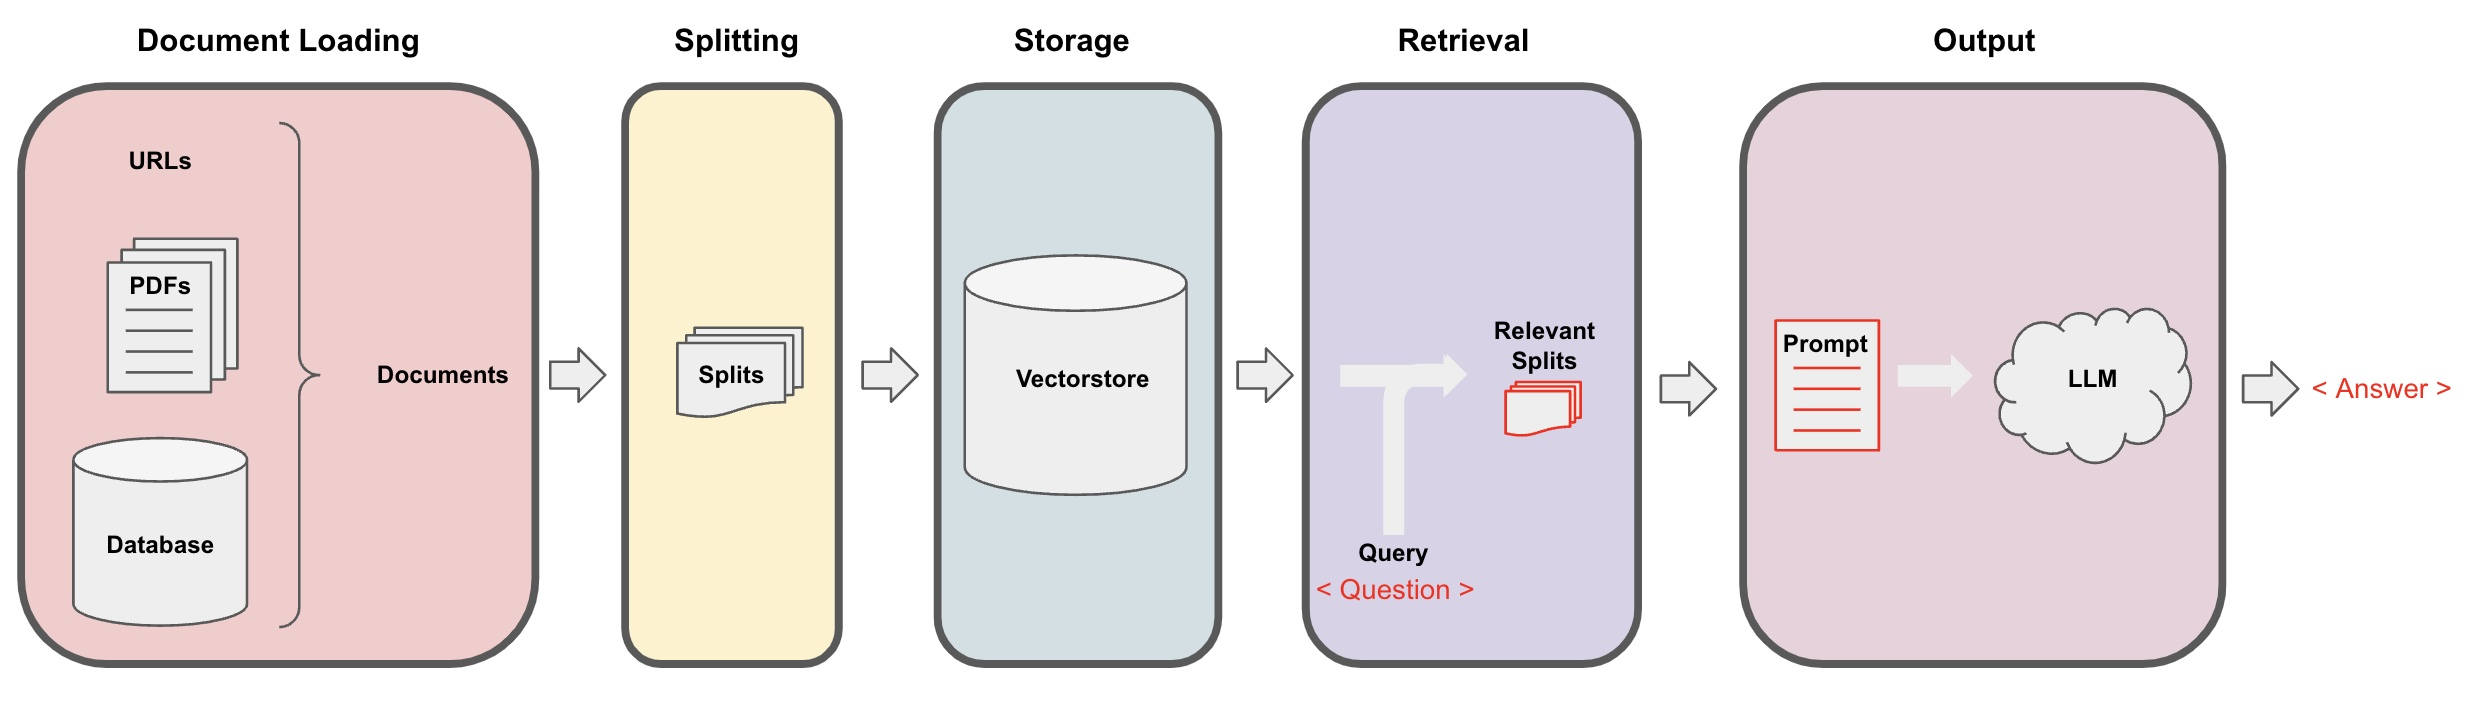

### Configuration - Use of OpenAI's API at Petrobras

In [1]:
import openai
import os
#from openai import AzureOpenAI #(Replaced for line below)
from langchain_openai import AzureOpenAI #Possible conflict with the line above
from configparser import ConfigParser, ExtendedInterpolation
import httpx

config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../config-v1.x.ini', 'UTF-8')

http_client = httpx.Client(verify='../petrobras-ca-root.pem')

client = AzureOpenAI(
    api_key=config['OPENAI']['OPENAI_API_KEY'],  
    api_version=config['OPENAI']['OPENAI_API_VERSION'],
    # azure_endpoint=config['OPENAI']['OPENAI_API_BASE'],
    base_url=config['OPENAI']['AZURE_OPENAI_BASE_URL'],
    http_client=http_client
)

## 1.Document Loading

In [ ]:
#! pip install langchain

### YouTube

In [49]:
#IT DIDN'T WORK!
#Original from 'Chat With Your Data' course.

#from langchain.document_loaders.generic import GenericLoader
#from langchain.document_loaders.parsers import OpenAIWhisperParser
#from langchain.document_loaders.blob_loaders.youtube_audio import YoutubeAudioLoader

In [4]:
#IT WORKED!
#Based on:
#https://python.langchain.com/docs/integrations/document_loaders/youtube_audio/
#https://api.python.langchain.com/en/latest/document_loaders/langchain_community.document_loaders.parsers.audio.OpenAIWhisperParser.html

from langchain_community.document_loaders.blob_loaders.youtube_audio import (
    YoutubeAudioLoader,
)
from langchain_community.document_loaders.generic import GenericLoader
from langchain_community.document_loaders.parsers.audio import OpenAIWhisperParser

In [ ]:
# ! pip install yt_dlp
# ! pip install pydub

#### IMPORTANT!

There isn't an OpenAI's endpoint for Speech to Text on Petrobras IA models Hub, according to Vinicius Braz Pinto (TIC/AID/IAA/IACD), on 03/05/24.

Therefore, the code below will save the video's audio on the indicated directory, but will not do the speech-to-text conversion.

In [9]:
url = "https://www.youtube.com/watch?v=PmhxOtaTPUI" #Mais que uma simples intuição

save_dir="../data/youtube/"

loader = GenericLoader(
    YoutubeAudioLoader([url], save_dir),
    OpenAIWhisperParser(api_key=os.environ.get("OPENAI_API_KEY"), base_url=os.environ.get("OPENAI_API_BASE"))
)
docs = loader.load()

[youtube] Extracting URL: https://www.youtube.com/watch?v=PmhxOtaTPUI
[youtube] PmhxOtaTPUI: Downloading webpage
[youtube] PmhxOtaTPUI: Downloading ios player API JSON
[youtube] PmhxOtaTPUI: Downloading android player API JSON


[youtube] PmhxOtaTPUI: Downloading m3u8 information
[info] PmhxOtaTPUI: Downloading 1 format(s): 140
[download] ../data/youtube//Mais que uma simples intuição.m4a has already been downloaded
[download] 100% of   30.02MiB
[ExtractAudio] Not converting audio ../data/youtube//Mais que uma simples intuição.m4a; file is already in target format m4a
Transcribing part 1!
Attempt 1 failed. Exception: Connection error.


KeyboardInterrupt: 

#### 1.1 Speech to Text (Alternative solution using Whisper)

Development based on tutorial available in: https://github.com/openai/whisper?tab=readme-ov-file#whisper

The notebook 'test_speech-to-text_whisper.ipynb' shows more details.

In [10]:
# pip install -U openai-whisper

In [ ]:
# Python usage: https://github.com/openai/whisper?tab=readme-ov-file#whisper

import whisper

AUDIOPATH = "../data/youtube/Mais que uma simples intuição.m4a"
model = whisper.load_model("base")
result = model.transcribe(AUDIOPATH)
print(result["text"])

Save the text in a file

In [ ]:
FILENAME = '../data/youtube/Mais que uma simples intuicao.txt'
with open(FILENAME, 'w') as arquivo:
    #Escreve o texto no arquivo
    arquivo.write(result['text'])

print("Texto salvo com sucesso!")

Testing opening's text file

In [1]:
FILENAME = '../data/youtube/Mais que uma simples intuicao.txt'

with open(FILENAME, 'r') as arquivo:
    #Lê o conteúdo do arquivo
    conteudo = arquivo.read()

    #Imprime o conteúdo na tela
    print(conteudo)

 Apenas de Apenas Olá, meu nome é Paul Green As técnicas que você aprenderá agora vêm de pesquisas publicadas e da minha própria experiência é a melhoris de entrevistas de seleção Esta combinação de ciência e prática o ajudará a conduzir entrevistas que prevenham o desempenho no trabalho oferecem proteção legal e mantenha dignidade dos candidatos É uma estratégia de entrevista comportamental porque daí fazia a obtenção de exemplos específicos do que a pessoa já fez para ajudá-lo a prever o que a pessoa pode fazer Ela se baseia na premissa de que o comportamento é constante As pessoas tendem a atuar no futuro da mesma forma que atuaram no passado Embora seja uma abordagem óbvia para o processo não é nada fácil de ser aplicada Para usar esta técnica corretamente você deve ir além das primeiras impressões exterior tipos e teorias particulares sobre as pessoas Então você poderá aplicar a abordagem comportamental e fazer sua avaliação usando mais do que uma simples impressão e fazer a sua a

As we have the video text, we go to next stage.

## 2.Document Splitting

There are many ways to split the text, and many of them are implemented on LangChain:

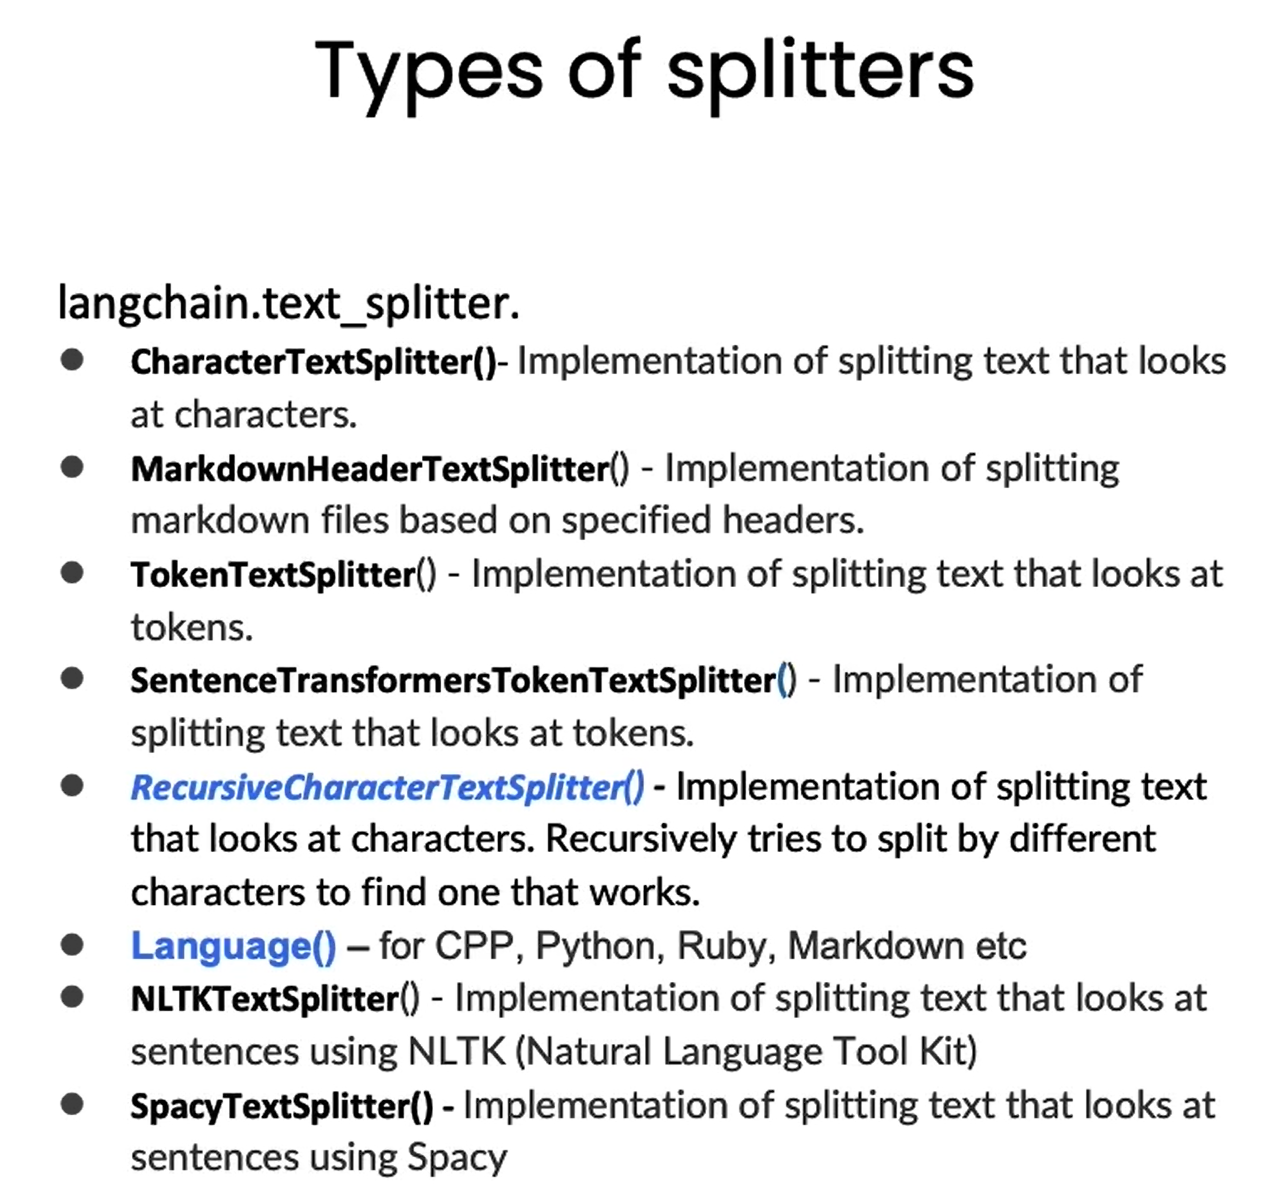

Let's explore some of them and, on the last section of this topic (2.3), define the split strategy that will be used do create the chunks.

### 2.1 `RecursiveCharacterTextSplitter` e `CharacterTexSplitter`

`RecursiveCharacterTextSplitter` is recommended for generic text.

`CharacterTextSplitter` splits on a single character and by default that character is a newline character.

In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter

In [2]:
chunk_size =26
chunk_overlap = 4

In [3]:
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
)
c_splitter = CharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
)

In [4]:
r_splitter.split_text(conteudo)

NameError: name 'conteudo' is not defined

`CharacterTextSplitter` splits texto ona newline character, by default.

In [ ]:
c_splitter.split_text(conteudo)

['Apenas de Apenas Olá, meu nome é Paul Green As técnicas que você aprenderá agora vêm de pesquisas publicadas e da minha própria experiência é a melhoris de entrevistas de seleção Esta combinação de ciência e prática o ajudará a conduzir entrevistas que prevenham o desempenho no trabalho oferecem proteção legal e mantenha dignidade dos candidatos É uma estratégia de entrevista comportamental porque daí fazia a obtenção de exemplos específicos do que a pessoa já fez para ajudá-lo a prever o que a pessoa pode fazer Ela se baseia na premissa de que o comportamento é constante As pessoas tendem a atuar no futuro da mesma forma que atuaram no passado Embora seja uma abordagem óbvia para o processo não é nada fácil de ser aplicada Para usar esta técnica corretamente você deve ir além das primeiras impressões exterior tipos e teorias particulares sobre as pessoas Então você poderá aplicar a abordagem comportamental e fazer sua avaliação usando mais do que uma simples impressão e fazer a sua 

If we set the separator to be an empty space, it splits text acordingly.

In [ ]:
c_splitter = CharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    separator = ' '
)
c_splitter.split_text(conteudo)

['Apenas de Apenas Olá, meu',
 'meu nome é Paul Green As',
 'As técnicas que você',
 'você aprenderá agora vêm',
 'vêm de pesquisas',
 'publicadas e da minha',
 'própria experiência é a',
 'é a melhoris de',
 'de entrevistas de seleção',
 'Esta combinação de ciência',
 'e prática o ajudará a',
 'a conduzir entrevistas que',
 'que prevenham o desempenho',
 'no trabalho oferecem',
 'proteção legal e mantenha',
 'dignidade dos candidatos É',
 'É uma estratégia de',
 'de entrevista',
 'comportamental porque daí',
 'daí fazia a obtenção de',
 'de exemplos específicos do',
 'do que a pessoa já fez',
 'fez para ajudá-lo a prever',
 'o que a pessoa pode fazer',
 'Ela se baseia na premissa',
 'de que o comportamento é',
 'é constante As pessoas',
 'tendem a atuar no futuro',
 'da mesma forma que atuaram',
 'no passado Embora seja uma',
 'uma abordagem óbvia para o',
 'o processo não é nada',
 'nada fácil de ser aplicada',
 'Para usar esta técnica',
 'corretamente você deve ir',
 'ir além das pr

In [ ]:
c_splitter = CharacterTextSplitter(
    chunk_size=450,
    chunk_overlap=0,
    separator = ' '
    #It splits os spaces. We end up with the weird separation in the middle of the sentence.
)
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=450,
    chunk_overlap=0, 
    separators=["\n\n", "\n", " ", ""]
    #These are the default separators: double newline, single newline, space and nothing (empty string).
    #They're here to better show what's going on.
    #What this means is that when you're splitting a piece of text it will firt try to split...
    #..by double newlines. And then, if it needs to do more it goes on the space...
    #..And then, if it still needs to split the individual chunks more it will go on to single newlines...
    #..and then, if it still needs to do more it goes on the space..
    #..and then, finally it will just go character by character if it really needs to do that.
)

By default, `CharacterTextSplitter` splits on a newline character.

In [ ]:
c_splitter.split_text(conteudo)

['Apenas de Apenas Olá, meu nome é Paul Green As técnicas que você aprenderá agora vêm de pesquisas publicadas e da minha própria experiência é a melhoris de entrevistas de seleção Esta combinação de ciência e prática o ajudará a conduzir entrevistas que prevenham o desempenho no trabalho oferecem proteção legal e mantenha dignidade dos candidatos É uma estratégia de entrevista comportamental porque daí fazia a obtenção de exemplos específicos do',
 'que a pessoa já fez para ajudá-lo a prever o que a pessoa pode fazer Ela se baseia na premissa de que o comportamento é constante As pessoas tendem a atuar no futuro da mesma forma que atuaram no passado Embora seja uma abordagem óbvia para o processo não é nada fácil de ser aplicada Para usar esta técnica corretamente você deve ir além das primeiras impressões exterior tipos e teorias particulares sobre as pessoas Então você poderá aplicar a',
 'abordagem comportamental e fazer sua avaliação usando mais do que uma simples impressão e faze

In [ ]:
r_splitter.split_text(conteudo)

['Apenas de Apenas Olá, meu nome é Paul Green As técnicas que você aprenderá agora vêm de pesquisas publicadas e da minha própria experiência é a melhoris de entrevistas de seleção Esta combinação de ciência e prática o ajudará a conduzir entrevistas que prevenham o desempenho no trabalho oferecem proteção legal e mantenha dignidade dos candidatos É uma estratégia de entrevista comportamental porque daí fazia a obtenção de exemplos específicos do',
 'que a pessoa já fez para ajudá-lo a prever o que a pessoa pode fazer Ela se baseia na premissa de que o comportamento é constante As pessoas tendem a atuar no futuro da mesma forma que atuaram no passado Embora seja uma abordagem óbvia para o processo não é nada fácil de ser aplicada Para usar esta técnica corretamente você deve ir além das primeiras impressões exterior tipos e teorias particulares sobre as pessoas Então você poderá aplicar a',
 'abordagem comportamental e fazer sua avaliação usando mais do que uma simples impressão e faze

In [ ]:
#To get smaller chunks, we can add a period (".") separator.
#This is aimed at splitting in between sentences.
#But this is not the better form to specify the period.
#See the next section with regex.
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=150,
    chunk_overlap=0,
    separators=["\n\n", "\n", "\. ", " ", ""]
)
r_splitter.split_text(conteudo)

['Apenas de Apenas Olá, meu nome é Paul Green As técnicas que você aprenderá agora vêm de pesquisas publicadas e da minha própria experiência é a',
 'melhoris de entrevistas de seleção Esta combinação de ciência e prática o ajudará a conduzir entrevistas que prevenham o desempenho no trabalho',
 'oferecem proteção legal e mantenha dignidade dos candidatos É uma estratégia de entrevista comportamental porque daí fazia a obtenção de exemplos',
 'específicos do que a pessoa já fez para ajudá-lo a prever o que a pessoa pode fazer Ela se baseia na premissa de que o comportamento é constante As',
 'pessoas tendem a atuar no futuro da mesma forma que atuaram no passado Embora seja uma abordagem óbvia para o processo não é nada fácil de ser',
 'aplicada Para usar esta técnica corretamente você deve ir além das primeiras impressões exterior tipos e teorias particulares sobre as pessoas Então',
 'você poderá aplicar a abordagem comportamental e fazer sua avaliação usando mais do que uma simples 

In [ ]:
#Regex to include the period "." separator: positive lookbehind ((?<=\. )
#It's useful to split sentences in an more efficient way: it captures text/string after a period and a space.
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=150,
    chunk_overlap=0,
    separators=["\n\n", "\n", "(?<=\. )", " ", ""]
)
r_splitter.split_text(conteudo)

['Apenas de Apenas Olá, meu nome é Paul Green As técnicas que você aprenderá agora vêm de pesquisas publicadas e da minha própria experiência é a',
 'melhoris de entrevistas de seleção Esta combinação de ciência e prática o ajudará a conduzir entrevistas que prevenham o desempenho no trabalho',
 'oferecem proteção legal e mantenha dignidade dos candidatos É uma estratégia de entrevista comportamental porque daí fazia a obtenção de exemplos',
 'específicos do que a pessoa já fez para ajudá-lo a prever o que a pessoa pode fazer Ela se baseia na premissa de que o comportamento é constante As',
 'pessoas tendem a atuar no futuro da mesma forma que atuaram no passado Embora seja uma abordagem óbvia para o processo não é nada fácil de ser',
 'aplicada Para usar esta técnica corretamente você deve ir além das primeiras impressões exterior tipos e teorias particulares sobre as pessoas Então',
 'você poderá aplicar a abordagem comportamental e fazer sua avaliação usando mais do que uma simples 

In [ ]:
c_splitter = CharacterTextSplitter(
    separator="\n",
    chunk_size=1000,
    chunk_overlap=150,
    length_function=len
    #Here we pass the length function using 'len'.
    #This is the default, but we're just specifying it for more clarity...
    #..what's going on underneath the scenes, and this is counting the length of the characters.
)

In [ ]:
c_splitter.split_text(conteudo)

['Apenas de Apenas Olá, meu nome é Paul Green As técnicas que você aprenderá agora vêm de pesquisas publicadas e da minha própria experiência é a melhoris de entrevistas de seleção Esta combinação de ciência e prática o ajudará a conduzir entrevistas que prevenham o desempenho no trabalho oferecem proteção legal e mantenha dignidade dos candidatos É uma estratégia de entrevista comportamental porque daí fazia a obtenção de exemplos específicos do que a pessoa já fez para ajudá-lo a prever o que a pessoa pode fazer Ela se baseia na premissa de que o comportamento é constante As pessoas tendem a atuar no futuro da mesma forma que atuaram no passado Embora seja uma abordagem óbvia para o processo não é nada fácil de ser aplicada Para usar esta técnica corretamente você deve ir além das primeiras impressões exterior tipos e teorias particulares sobre as pessoas Então você poderá aplicar a abordagem comportamental e fazer sua avaliação usando mais do que uma simples impressão e fazer a sua 

### 2.2 `Token splitting`

We can also split on token count explicity, if we want.

This can be useful because LLMs often have context windows designated in tokens.

Tokens are often ~4 characters.

In [ ]:
from langchain.text_splitter import TokenTextSplitter

In [ ]:
text_splitter = TokenTextSplitter(
    chunk_size=1,
    chunk_overlap=0
    #This will split any text into a list of relevant tokens.
    )

In [ ]:
text_splitter.split_text(conteudo)

[' A',
 'pen',
 'as',
 ' de',
 ' A',
 'pen',
 'as',
 ' Ol',
 'á',
 ',',
 ' me',
 'u',
 ' n',
 'ome',
 ' é',
 ' Paul',
 ' Green',
 ' As',
 ' t',
 'é',
 'c',
 'nic',
 'as',
 ' que',
 ' voc',
 'ê',
 ' ap',
 'render',
 'á',
 ' ag',
 'ora',
 ' v',
 'ê',
 'm',
 ' de',
 ' pes',
 'qu',
 'is',
 'as',
 ' public',
 'adas',
 ' e',
 ' da',
 ' min',
 'ha',
 ' pr',
 'ó',
 'pri',
 'a',
 ' exper',
 'i',
 'ê',
 'nc',
 'ia',
 ' é',
 ' a',
 ' mel',
 'hor',
 'is',
 ' de',
 ' ent',
 'rev',
 'istas',
 ' de',
 ' se',
 'le',
 'ç',
 'ão',
 ' Est',
 'a',
 ' comb',
 'ina',
 'ç',
 'ão',
 ' de',
 ' c',
 'i',
 'ê',
 'nc',
 'ia',
 ' e',
 ' pr',
 'á',
 't',
 'ica',
 ' o',
 ' a',
 'jud',
 'ar',
 'á',
 ' a',
 ' condu',
 'z',
 'ir',
 ' ent',
 'rev',
 'istas',
 ' que',
 ' pre',
 'ven',
 'ham',
 ' o',
 ' des',
 'em',
 'pen',
 'ho',
 ' no',
 ' tr',
 'abal',
 'ho',
 ' of',
 'ere',
 'ce',
 'm',
 ' prote',
 'ç',
 'ão',
 ' legal',
 ' e',
 ' mant',
 'en',
 'ha',
 ' dign',
 'id',
 'ade',
 ' dos',
 ' candid',
 'atos',
 ' É',
 ' u'

In [ ]:
text_splitter = TokenTextSplitter(
    chunk_size=10,
    chunk_overlap=0
    )

In [ ]:
text_splitter.split_text(conteudo)

[' Apenas de Apenas Olá,',
 ' meu nome é Paul Green As té',
 'cnicas que você aprenderá ag',
 'ora vêm de pesquisas public',
 'adas e da minha própria exper',
 'iência é a melhoris de',
 ' entrevistas de seleção Esta',
 ' combinação de ciência',
 ' e prática o ajudará',
 ' a conduzir entrevistas que preven',
 'ham o desempenho no trabalho',
 ' oferecem proteção legal e mant',
 'enha dignidade dos candidatos É u',
 'ma estratégia de entrevista',
 ' comportamental porque daí fazia',
 ' a obtenção de exemplos espec',
 'íficos do que a pessoa',
 ' já fez para ajudá-lo',
 ' a prever o que a pessoa p',
 'ode fazer Ela se baseia na pre',
 'missa de que o comportamento é',
 ' constante As pessoas tendem a',
 ' atuar no futuro da mesma form',
 'a que atuaram no passado Embora',
 ' seja uma abordagem ó',
 'bvia para o processo não é n',
 'ada fácil de ser aplicada',
 ' Para usar esta técnica',
 ' corretamente você deve ir al',
 'ém das primeiras impressõ',
 'es exterior tipos e teorias particul'

### 2.3 SPLIT STRATEGY SELECTED: `RecursiveCharacterTextSplitter`

In [ ]:
#Regex to include de periodo "." separator: positive lookbehind ((?<=\. )
#It's useful to split sentences in an more efficient way: it captures text/string after a period and a space.

from langchain.text_splitter import RecursiveCharacterTextSplitter

r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=150,
    separators=["\n\n", "\n", "(?<=\. )", " ", ""]
)
splits = r_splitter.split_text(conteudo)
print(len(splits))
splits

24


['Apenas de Apenas Olá, meu nome é Paul Green As técnicas que você aprenderá agora vêm de pesquisas publicadas e da minha própria experiência é a melhoris de entrevistas de seleção Esta combinação de ciência e prática o ajudará a conduzir entrevistas que prevenham o desempenho no trabalho oferecem proteção legal e mantenha dignidade dos candidatos É uma estratégia de entrevista comportamental porque daí fazia a obtenção de exemplos específicos do que a pessoa já fez para ajudá-lo a prever o que a pessoa pode fazer Ela se baseia na premissa de que o comportamento é constante As pessoas tendem a atuar no futuro da mesma forma que atuaram no passado Embora seja uma abordagem óbvia para o processo não é nada fácil de ser aplicada Para usar esta técnica corretamente você deve ir além das primeiras impressões exterior tipos e teorias particulares sobre as pessoas Então você poderá aplicar a abordagem comportamental e fazer sua avaliação usando mais do que uma simples impressão e fazer a sua 

## 3.Vectorstores and Embeddings

### 3.1 Embeddings - Petrobras Mode

In [9]:
#Função para obter as embeddings
#Fonte: https://codigo-externo.petrobras.com.br/cd-petrobras/model-ops/-/blob/main/hub-modelos-ia/exemplo-consumo-modelo/Python%20OpenAI%201.X.ipynb

import os
from openai import AzureOpenAI
from configparser import ConfigParser, ExtendedInterpolation
import httpx
import numpy as np

config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../config-v1.x.ini', 'UTF-8')

http_client = httpx.Client(verify='../petrobras-ca-root.pem')

client = AzureOpenAI(
    api_key=config['OPENAI']['OPENAI_API_KEY'],  
    api_version=config['OPENAI']['OPENAI_API_VERSION'],
    # azure_endpoint=config['OPENAI']['OPENAI_API_BASE'],
    base_url=config['OPENAI']['AZURE_OPENAI_BASE_URL'],
    http_client=http_client
)

In [10]:
def get_embedding(text, engine, **kwargs):
    response = client.embeddings.create(
        # Contact your team admin to get the name of your engine or model deployment.  
        # This is the name that they used when they created the model deployment.
        input=text,
        model=engine,
        **kwargs
    )

    embeddings = response.data[0].embedding
    return np.array(embeddings)

In [19]:
get_embedding(text="Olá, mundo!", engine=config['OPENAI']['EMBEDDINGS_MODEL'])

array([ 0.00354683, -0.00342365,  0.00281725, ..., -0.00982879,
        0.00267986, -0.02280331])

### 3.2 Embeddings - Via LangChain

In [12]:
#Source (we provided this code for Petrobras documentation): https://codigo-externo.petrobras.com.br/cd-petrobras/model-ops/-/blob/main/hub-modelos-ia/exemplo-consumo-modelo/langchain.ipynb
#Documentation: https://python.langchain.com/v0.1/docs/integrations/text_embedding/azureopenai/

from langchain_openai import AzureOpenAIEmbeddings
from httpx import Client
from configparser import ConfigParser, ExtendedInterpolation

config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../config-v1.x.ini', 'UTF-8')

CERTIFICATE_PATH = '../petrobras-ca-root.pem'

OPENAI_API_VERSION = '2024-03-01-preview'
OPENAI_BASE_URL = 'https://apid.petrobras.com.br/ia/openai/v1/openai-azure/openai/deployments'
EMBEDDINGS_DEPLOYMENT_NAME='text-embedding-petrobras'

embedding = AzureOpenAIEmbeddings(
    model=EMBEDDINGS_DEPLOYMENT_NAME,
    openai_api_version=OPENAI_API_VERSION,
    openai_api_key=config['OPENAI']['OPENAI_API_KEY'],
    base_url=f'{OPENAI_BASE_URL}/{EMBEDDINGS_DEPLOYMENT_NAME}',
    http_client=Client(verify=CERTIFICATE_PATH)
)

print(embedding.embed_query('this is a test document'))

[-0.012051375136090964, 0.007208299090245095, -0.014602106454606233, -0.026686607802125763, -0.003488207339461291, 0.024487015814869378, -0.010593814382653667, -0.004223612911899525, -0.016072917133821432, -0.024606271666128283, 0.014032332637802741, 0.027799653721531863, -0.019253048332124566, 0.027720150441574283, -0.0012000029228979921, 0.019080792777754048, 0.015503143317017942, -0.01225013333598491, 0.004173923129095404, -0.015450141751261248, 0.0017739173997147373, 0.0001171845535499541, -0.01771598616137477, 0.007956955286953138, -0.0181797549840198, -0.006512645390616284, 0.01735822047024313, -0.03344438846116501, 0.006419891719219533, -0.00511139984853333, 0.0012248476978847355, -0.01315779655826938, -0.007440183967228879, -0.035140457191829955, -0.004959018251507126, 0.0038294089935561096, -0.009851784080157116, -0.038691604938365175, 0.02442076339201224, -0.017517227030158285, 0.0053697855083954605, 0.007122170847398565, 0.0025308550328646045, -0.010229424194294344, 0.005952

Examples

In [4]:
sentence1 = "i like dogs"
sentence2 = "i like canines"
sentence3 = "the weather is ugly outside"

In [14]:
embedding1 = embedding.embed_query(sentence1)
embedding2 = embedding.embed_query(sentence2)
embedding3 = embedding.embed_query(sentence3)

In [15]:
import numpy as np

Similarity (dot product)

In [16]:
np.dot(embedding1, embedding2)

0.9629478572630685

In [17]:
np.dot(embedding1, embedding3)

0.7700566174953768

In [18]:
np.dot(embedding2, embedding3)

0.7588785743809341

### 3.3 Vectorstore

It's time to create embeddings for all the chunks of the video (text) and then store them in a vector store (Chroma).

Obs.: Langchain has integration with more than 30 different vector stores.

In [ ]:
# ! pip install chromadb

In [5]:
from langchain.vectorstores import Chroma

In [6]:
persist_directory = '../data/chroma/'

In [8]:
!rm -rf ../data/chroma  # remove old database files if any

In [21]:
vectordb = Chroma.from_texts(
    texts=splits,
    embedding=embedding,
    persist_directory=persist_directory
)

The collection count should be the same as the number of splits that we had from before.

In [23]:
print(len(splits))
print(vectordb._collection.count())

24
24


Let's start using it!

### 3.4 Similarity Search

In [24]:
question = "o que se deve perguntar ao candidato na entrevista"

In [25]:
docs = vectordb.similarity_search(question,k=3) #'k' specifies the number of documents we want to return

In [26]:
len(docs)

3

In [29]:
#The first of three documents most similars 
docs[0].page_content

'para que o candidato forneça detalhes E não se esqueça do silêncio Sim, eu permito o silêncio caso precisa de tempo para pensar Naturalmente ouço com atenção e avaliu as respostas Busco evidências contrárias para não ter uma imagem unilateral do candidato E mantenha o controle fazendo outra pergunta com o objetivo de redirecionar o entrevistado Se eu achar que ele fugiu do assunto Bem, esta foi uma excelente entrevista hein Então, há alguma coisa que você quer me perguntar ou algo que eu deveria ter ali perguntado e não perguntem? Não, o senhor foi meticuloso Mas devo admitir, estou bem mais acostumado a estar do outro lado da mesa Isso foi um pouco incomum Como me saí? Ah, você deu informações muito boa Ótimo Mas você já sabe que preciso de tempo para avaliar e que também vou entrevistar outros candidatos nesta semana Sim, é claro Entrarem em contato no final da semana que vem Eu estarei aguardando Obrigado, hein Obrigada Até mais Até logo Olá, como foi a entrevista? Muito bem Agora 

Let's save/persist the vector database so that we can use it in future.

In [30]:
vectordb.persist()

/home/usz0/mvp-rag-langchain/env-mvp-rag/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


Important: FAILURE MODES

Semantic search seems great.
However, there are situations in which we can have problems:
- duplicate chunks: semantic search fetches all similar documents, but does not enforce diversity;
- when i want information of a specific document on the vector database: that's a piece of structured information that isn't really perfectly captured in this semantic embedding that we've created.

The good news is that there are ways to solve it!

## 4. Retrieval

In [2]:
from langchain_openai import AzureOpenAIEmbeddings
from httpx import Client
from configparser import ConfigParser, ExtendedInterpolation

config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../config-v1.x.ini', 'UTF-8')

CERTIFICATE_PATH = '../petrobras-ca-root.pem'

OPENAI_API_VERSION = '2024-03-01-preview'
OPENAI_BASE_URL = 'https://apid.petrobras.com.br/ia/openai/v1/openai-azure/openai/deployments'
EMBEDDINGS_DEPLOYMENT_NAME='text-embedding-petrobras'

embedding = AzureOpenAIEmbeddings(
    model=EMBEDDINGS_DEPLOYMENT_NAME,
    openai_api_version=OPENAI_API_VERSION,
    openai_api_key=config['OPENAI']['OPENAI_API_KEY'],
    base_url=f'{OPENAI_BASE_URL}/{EMBEDDINGS_DEPLOYMENT_NAME}',
    http_client=Client(verify=CERTIFICATE_PATH)
)

print(embedding.embed_query('this is a test document'))

[-0.012051375136090964, 0.007208299090245095, -0.014602106454606233, -0.026686607802125763, -0.003488207339461291, 0.024487015814869378, -0.010593814382653667, -0.004223612911899525, -0.016072917133821432, -0.024606271666128283, 0.014032332637802741, 0.027799653721531863, -0.019253048332124566, 0.027720150441574283, -0.0012000029228979921, 0.019080792777754048, 0.015503143317017942, -0.01225013333598491, 0.004173923129095404, -0.015450141751261248, 0.0017739173997147373, 0.0001171845535499541, -0.01771598616137477, 0.007956955286953138, -0.0181797549840198, -0.006512645390616284, 0.01735822047024313, -0.03344438846116501, 0.006419891719219533, -0.00511139984853333, 0.0012248476978847355, -0.01315779655826938, -0.007440183967228879, -0.035140457191829955, -0.004959018251507126, 0.0038294089935561096, -0.009851784080157116, -0.038691604938365175, 0.02442076339201224, -0.017517227030158285, 0.0053697855083954605, 0.007122170847398565, 0.0025308550328646045, -0.010229424194294344, 0.005952

In [3]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
persist_directory = '../data/chroma/'

In [4]:
vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding
)

In [5]:
print(vectordb._collection.count())

24


In [6]:
question = "o que se deve perguntar ao candidato na entrevista"

In [7]:
vectordb.similarity_search(question, k=2)

[Document(page_content='para que o candidato forneça detalhes E não se esqueça do silêncio Sim, eu permito o silêncio caso precisa de tempo para pensar Naturalmente ouço com atenção e avaliu as respostas Busco evidências contrárias para não ter uma imagem unilateral do candidato E mantenha o controle fazendo outra pergunta com o objetivo de redirecionar o entrevistado Se eu achar que ele fugiu do assunto Bem, esta foi uma excelente entrevista hein Então, há alguma coisa que você quer me perguntar ou algo que eu deveria ter ali perguntado e não perguntem? Não, o senhor foi meticuloso Mas devo admitir, estou bem mais acostumado a estar do outro lado da mesa Isso foi um pouco incomum Como me saí? Ah, você deu informações muito boa Ótimo Mas você já sabe que preciso de tempo para avaliar e que também vou entrevistar outros candidatos nesta semana Sim, é claro Entrarem em contato no final da semana que vem Eu estarei aguardando Obrigado, hein Obrigada Até mais Até logo Olá, como foi a entre

#### Addressing Diversity: Maximum marginal relevance

Last class we introduced one problem: how to enforce diversity in the search results.
 
`Maximum marginal relevance` strives to achieve both relevance to the query *and diversity* among the results.

In [8]:
vectordb.max_marginal_relevance_search(question, k=3)

[Document(page_content='para que o candidato forneça detalhes E não se esqueça do silêncio Sim, eu permito o silêncio caso precisa de tempo para pensar Naturalmente ouço com atenção e avaliu as respostas Busco evidências contrárias para não ter uma imagem unilateral do candidato E mantenha o controle fazendo outra pergunta com o objetivo de redirecionar o entrevistado Se eu achar que ele fugiu do assunto Bem, esta foi uma excelente entrevista hein Então, há alguma coisa que você quer me perguntar ou algo que eu deveria ter ali perguntado e não perguntem? Não, o senhor foi meticuloso Mas devo admitir, estou bem mais acostumado a estar do outro lado da mesa Isso foi um pouco incomum Como me saí? Ah, você deu informações muito boa Ótimo Mas você já sabe que preciso de tempo para avaliar e que também vou entrevistar outros candidatos nesta semana Sim, é claro Entrarem em contato no final da semana que vem Eu estarei aguardando Obrigado, hein Obrigada Até mais Até logo Olá, como foi a entre

There are other retrieval techniques that can be used:

- Addressing Specificity: working with metadata

- Addressing Specificity: working with metadata using self-query retriever

- Additional tricks: compression

#### Other types of retrieval

It's worth noting that vectordb as not the only kind of tool to retrieve documents. 

The `LangChain` retriever abstraction includes other ways to retrieve documents, such as TF-IDF or SVM.

In [9]:
from langchain.retrievers import SVMRetriever
from langchain.retrievers import TFIDFRetriever
from langchain.text_splitter import RecursiveCharacterTextSplitter

Opening the text file

In [10]:
FILENAME = '../data/youtube/Mais que uma simples intuicao.txt'

with open(FILENAME, 'r') as arquivo:
    #Lê o conteúdo do arquivo
    conteudo = arquivo.read()

    #Imprime o conteúdo na tela
    print(conteudo)

 Apenas de Apenas Olá, meu nome é Paul Green As técnicas que você aprenderá agora vêm de pesquisas publicadas e da minha própria experiência é a melhoris de entrevistas de seleção Esta combinação de ciência e prática o ajudará a conduzir entrevistas que prevenham o desempenho no trabalho oferecem proteção legal e mantenha dignidade dos candidatos É uma estratégia de entrevista comportamental porque daí fazia a obtenção de exemplos específicos do que a pessoa já fez para ajudá-lo a prever o que a pessoa pode fazer Ela se baseia na premissa de que o comportamento é constante As pessoas tendem a atuar no futuro da mesma forma que atuaram no passado Embora seja uma abordagem óbvia para o processo não é nada fácil de ser aplicada Para usar esta técnica corretamente você deve ir além das primeiras impressões exterior tipos e teorias particulares sobre as pessoas Então você poderá aplicar a abordagem comportamental e fazer sua avaliação usando mais do que uma simples impressão e fazer a sua a

In [11]:
# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1500,chunk_overlap = 150)
splits = text_splitter.split_text(conteudo)

In [12]:
# Retrieve
svm_retriever = SVMRetriever.from_texts(splits,embedding)
tfidf_retriever = TFIDFRetriever.from_texts(splits)

In [17]:
#SVM
question = "o que se deve perguntar ao candidato na entrevista"
docs_svm=svm_retriever.get_relevant_documents(question)
docs_svm[0]

/home/usz0/mvp-rag-langchain/env-mvp-rag/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
/home/usz0/mvp-rag-langchain/env-mvp-rag/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Document(page_content='que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um alô que pode ser um a

In [13]:
#TF-IDF
docs_tfidf=tfidf_retriever.get_relevant_documents(question)
docs_tfidf[0]

/home/usz0/mvp-rag-langchain/env-mvp-rag/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Document(page_content='é preciso praticar as habilidades Depois você deve monitorar seu uso delas Em algumas coisas para você avaliar a praticar e monitorar sua eficiência como entrevistador Você usou uma entrevista estruturada? Ela continha questões abertas sobre ocasiões específicas em que o candidato usou habilidades relacionadas ao trabalho Obteve exemplos comportamentais? Viu o candidato parar para pensar e depois responder com um exemplo específico de uma situação em que a habilidade foi usada? Você estabeleceu a interação e discutiu o trabalho? Tolerou o silêncio? Pediu a informação contrária? Fez anotações e interrompeu sutilmente para redirecionar a entrevista? A entrevista eficiente é uma técnica complexa que exige manutenção do aprendizado É muito fácil fazer julgamentos rápidos, reduzir a entrevista Ou não se esforçar para obter informações relacionadas ao trabalho No nível mais básico isso se resume a perguntar a si mesmo Se você foi eficiente em obter informações de quali

## 5. Question Answering

In [15]:
from langchain_openai import AzureChatOpenAI
from httpx import Client
from configparser import ConfigParser, ExtendedInterpolation

config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../config-v1.x.ini', 'UTF-8')

CERTIFICATE_PATH = '../petrobras-ca-root.pem'

OPENAI_API_VERSION = '2024-03-01-preview'
OPENAI_BASE_URL = 'https://apid.petrobras.com.br/ia/openai/v1/openai-azure/openai/deployments'

# Exemplo de uso do GPT
DEPLOYMENT_NAME = 'gpt-35-turbo-petrobras'
llm = AzureChatOpenAI(
    model=DEPLOYMENT_NAME,
    openai_api_version=OPENAI_API_VERSION,
    openai_api_key=config['OPENAI']['OPENAI_API_KEY'],
    base_url=f'{OPENAI_BASE_URL}/{DEPLOYMENT_NAME}',
    verbose=True,
    http_client=Client(verify=CERTIFICATE_PATH)
)

In [ ]:
#from langchain.chat_models import ChatOpenAI
#llm = ChatOpenAI(model_name=llm_name, temperature=0)

### RetrievalQA chain

In [14]:
from langchain.chains import RetrievalQA

In [16]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

In [17]:
result = qa_chain({"query": question})

/home/usz0/mvp-rag-langchain/env-mvp-rag/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


In [18]:
result["result"]

'As perguntas a serem feitas durante uma entrevista podem variar dependendo do cargo e das necessidades da empresa. No entanto, aqui estão algumas perguntas comuns que podem ser feitas a um candidato durante uma entrevista:\n\n1. Fale um pouco sobre você e sua experiência profissional.\n2. Quais são suas principais habilidades e qualificações para esta posição?\n3. Como você lida com situações de pressão e estresse?\n4. Descreva uma situação em que você teve que lidar com um cliente difícil e como você resolveu o problema.\n5. Como você trabalha em equipe e colabora com colegas de trabalho?\n6. Descreva um projeto ou conquista de trabalho de que você se orgulha e explique seu papel nele.\n7. Como você se mantém atualizado em relação às tendências e mudanças em sua área de atuação?\n8. Como você lida com feedback construtivo e como você busca melhorar continuamente?\n9. Descreva uma situação em que você teve que resolver um problema complexo de forma criativa.\n10. Quais são seus objeti

### Prompt

In [19]:
from langchain.prompts import PromptTemplate

# Build prompt
template = """Utilize as seguintes partes de contexto para responder a questão ao final. Se você não souber a resposta, apenas diga que não sabe, não tente inventar uma resposta. Utilize o máximo de três sentenças. Mantenha a resposta mais concisa possível. Sempre diga "Obrigado por perguntar!" ao final da resposta. 
{context}
Question: {question}
Resposta útil:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

In [20]:
# Run chain
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [21]:
result = qa_chain({"query": question})

In [22]:
result["result"]

'Deve-se fazer perguntas abertas sobre suas experiências profissionais anteriores e buscar respostas específicas. Além disso, é importante fazer perguntas relacionadas às habilidades técnicas e de performance exigidas para o trabalho. Também é necessário fazer perguntas sobre como o candidato lida com problemas específicos relacionados à vaga. Obrigado por perguntar!'

In [23]:
result["source_documents"][0]

Document(page_content='para que o candidato forneça detalhes E não se esqueça do silêncio Sim, eu permito o silêncio caso precisa de tempo para pensar Naturalmente ouço com atenção e avaliu as respostas Busco evidências contrárias para não ter uma imagem unilateral do candidato E mantenha o controle fazendo outra pergunta com o objetivo de redirecionar o entrevistado Se eu achar que ele fugiu do assunto Bem, esta foi uma excelente entrevista hein Então, há alguma coisa que você quer me perguntar ou algo que eu deveria ter ali perguntado e não perguntem? Não, o senhor foi meticuloso Mas devo admitir, estou bem mais acostumado a estar do outro lado da mesa Isso foi um pouco incomum Como me saí? Ah, você deu informações muito boa Ótimo Mas você já sabe que preciso de tempo para avaliar e que também vou entrevistar outros candidatos nesta semana Sim, é claro Entrarem em contato no final da semana que vem Eu estarei aguardando Obrigado, hein Obrigada Até mais Até logo Olá, como foi a entrev

### RetrievalQA chain types

In [24]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce"
)

In [25]:
result = qa_chain_mr({"query": question})

In [26]:
result["result"]

'No trecho fornecido, não há informações específicas sobre o que deve ser perguntado ao candidato durante a entrevista.'

### RetrievalQA limitations
 
QA fails to preserve conversational history.

In [28]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

In [30]:
question = "O que é melhor perguntar para obter informações objetivas do candidato?"
result = qa_chain({"query": question})
result["result"]

'Para obter informações objetivas do candidato, é recomendado fazer perguntas abertas sobre suas experiências profissionais anteriores e insistir em respostas específicas. Por exemplo, você pode perguntar sobre situações desafiadoras que o candidato enfrentou no trabalho anterior e como ele lidou com elas. Essas perguntas ajudam a obter informações concretas sobre as habilidades e competências do candidato.'

In [31]:
question = "Porquê essas informações objetivas são importantes?"
result = qa_chain({"query": question})
result["result"]

'Essas informações objetivas são importantes porque ajudam a avaliar de forma justa e imparcial os candidatos durante uma entrevista de emprego. Ao buscar detalhes e evidências contrárias, é possível obter uma imagem mais completa e precisa do candidato, evitando julgamentos unilaterais ou baseados apenas em intuição. Além disso, as informações objetivas são mais relevantes para a seleção de candidatos com base em suas habilidades profissionais, em vez de características pessoais que possam levar à discriminação.'

Note, The LLM response varies. Some responses **do** include a reference to probability which might be gleaned from referenced documents. The point is simply that the model does not have access to past questions or answers, this will be covered in the next section.

## 6. Chat

In [33]:
# Build prompt
from langchain.prompts import PromptTemplate
template = """Utilize as seguintes partes de contexto para responder a questão ao final. Se você não souber a resposta, apenas diga que não sabe, não tente inventar uma resposta. Utilize o máximo de três sentenças. Mantenha a resposta mais concisa possível. Sempre diga "Obrigado por perguntar!" ao final da resposta. 
{context}
Question: {question}
Resposta útil:"""
QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],template=template,)

# Run chain
from langchain.chains import RetrievalQA
question = "o que se deve perguntar ao candidato na entrevista?"
qa_chain = RetrievalQA.from_chain_type(llm,
                                       retriever=vectordb.as_retriever(),
                                       return_source_documents=True,
                                       chain_type_kwargs={"prompt": QA_CHAIN_PROMPT})


result = qa_chain({"query": question})
result["result"]

'Deve-se fazer perguntas abertas sobre suas experiências profissionais anteriores e insistir em respostas específicas. Também é importante fazer perguntas relacionadas às habilidades técnicas e de performance necessárias para o trabalho.'

#### Memory

In [34]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

#### ConversationalRetrievalChain

In [35]:
from langchain.chains import ConversationalRetrievalChain
retriever=vectordb.as_retriever()
qa = ConversationalRetrievalChain.from_llm(
    llm,
    retriever=retriever,
    memory=memory
)

In [36]:
question = "o que se deve perguntar ao candidato na entrevista?"
result = qa({"question": question})

In [37]:
result['answer']

'Ao entrevistar um candidato, algumas perguntas que você pode fazer incluem:\n\n1. Fale sobre sua experiência relevante para a posição.\n2. Quais são suas principais habilidades e como você as aplicaria neste trabalho?\n3. Conte-me sobre um desafio que você enfrentou no trabalho anterior e como o superou.\n4. Como você lida com o estresse e prazos apertados?\n5. Como você se comunica e trabalha em equipe?\n6. Quais são suas expectativas em relação a esta posição?\n7. Como você lida com feedback construtivo?\n8. Descreva uma situação em que você precisou resolver um problema complexo.\n9. Como você se mantém atualizado em relação às últimas tendências e desenvolvimentos em sua área?\n10. O que você considera ser seu maior ponto forte e como isso se encaixa nesta posição?\n\nLembre-se de adaptar essas perguntas de acordo com as necessidades específicas do trabalho e da empresa.'

In [38]:
question = "E se eu não fizer a primeira pergunta?"
result = qa({"question": question})

In [39]:
result['answer']

'A primeira pergunta na entrevista é importante porque estabelece o tom e a direção da conversa. Ela ajuda a quebrar o gelo e a estabelecer uma conexão inicial com o candidato. Além disso, a primeira pergunta pode fornecer informações valiosas sobre a experiência e as habilidades do candidato, permitindo que o entrevistador avalie se ele é adequado para a vaga. Portanto, a primeira pergunta é crucial para iniciar a entrevista de forma eficaz e obter insights iniciais sobre o candidato.'

### 7. Create a chatbot that works on your documents (PDF)

In [1]:
#from langchain.embeddings.openai import OpenAIEmbeddings
#from langchain.chat_models import ChatOpenAI
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.document_loaders import TextLoader
from langchain.chains import RetrievalQA,  ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from httpx import Client
from configparser import ConfigParser, ExtendedInterpolation

In [2]:
config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../config-v1.x.ini', 'UTF-8')

CERTIFICATE_PATH = '../petrobras-ca-root.pem'

OPENAI_API_VERSION = '2024-03-01-preview'
OPENAI_BASE_URL = 'https://apid.petrobras.com.br/ia/openai/v1/openai-azure/openai/deployments'

#CHAT
# Exemplo de uso do GPT
DEPLOYMENT_NAME = 'gpt-35-turbo-petrobras'
llm = AzureChatOpenAI(
    model=DEPLOYMENT_NAME,
    openai_api_version=OPENAI_API_VERSION,
    openai_api_key=config['OPENAI']['OPENAI_API_KEY'],
    base_url=f'{OPENAI_BASE_URL}/{DEPLOYMENT_NAME}',
    verbose=True,
    http_client=Client(verify=CERTIFICATE_PATH)
)

#EMBEDDINGS
EMBEDDINGS_DEPLOYMENT_NAME='text-embedding-petrobras'

embedding = AzureOpenAIEmbeddings(
    model=EMBEDDINGS_DEPLOYMENT_NAME,
    openai_api_version=OPENAI_API_VERSION,
    openai_api_key=config['OPENAI']['OPENAI_API_KEY'],
    base_url=f'{OPENAI_BASE_URL}/{EMBEDDINGS_DEPLOYMENT_NAME}',
    http_client=Client(verify=CERTIFICATE_PATH)
)

The chatbot code has been updated a bit since filming. The GUI appearance also varies depending on the platform it is running on.

In [3]:
def load_db(file, chain_type, k):
    # load documents
    loader = PyPDFLoader(file)
    documents = loader.load()
    # split documents
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
    docs = text_splitter.split_documents(documents)
    # create vector database from data
    db = DocArrayInMemorySearch.from_documents(docs, embedding)
    # define retriever
    retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": k})
    # create a chatbot chain. Memory is managed externally.
    qa = ConversationalRetrievalChain.from_llm(
        llm, 
        chain_type=chain_type, 
        retriever=retriever, 
        return_source_documents=True,
        return_generated_question=True,
    )
    return qa

In [4]:
import panel as pn
pn.extension()
import param

class cbfs(param.Parameterized):
    chat_history = param.List([])
    answer = param.String("")
    db_query  = param.String("")
    db_response = param.List([])
    
    def __init__(self,  **params):
        super(cbfs, self).__init__( **params)
        self.panels = []
        #self.loaded_file = "docs/cs229_lectures/MachineLearning-Lecture01.pdf"
        self.loaded_file = "../data/The-Big-Book-of-MLOps-v6-082322.pdf"
        self.qa = load_db(self.loaded_file,"stuff", 4)
    
    def call_load_db(self, count):
        if count == 0 or file_input.value is None:  # init or no file specified :
            return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")
        else:
            file_input.save("temp.pdf")  # local copy
            self.loaded_file = file_input.filename
            button_load.button_style="outline"
            self.qa = load_db("temp.pdf", "stuff", 4)
            button_load.button_style="solid"
        self.clr_history()
        return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")

    def convchain(self, query):
        if not query:
            return pn.WidgetBox(pn.Row('User:', pn.pane.Markdown("", width=600)), scroll=True)
        result = self.qa({"question": query, "chat_history": self.chat_history})
        self.chat_history.extend([(query, result["answer"])])
        self.db_query = result["generated_question"]
        self.db_response = result["source_documents"]
        self.answer = result['answer'] 
        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=600)),
            #pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=600, style={'background-color': '#F6F6F6'}))
            pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=600))
        ])
        inp.value = ''  #clears loading indicator when cleared
        return pn.WidgetBox(*self.panels,scroll=True)

    @param.depends('db_query ', )
    def get_lquest(self):
        if not self.db_query :
            return pn.Column(
                pn.Row(pn.pane.Markdown(f"Last question to DB:", styles={'background-color': '#F6F6F6'})),
                pn.Row(pn.pane.Str("no DB accesses so far"))
            )
        return pn.Column(
            pn.Row(pn.pane.Markdown(f"DB query:", styles={'background-color': '#F6F6F6'})),
            pn.pane.Str(self.db_query )
        )

    @param.depends('db_response', )
    def get_sources(self):
        if not self.db_response:
            return 
        rlist=[pn.Row(pn.pane.Markdown(f"Result of DB lookup:", styles={'background-color': '#F6F6F6'}))]
        for doc in self.db_response:
            rlist.append(pn.Row(pn.pane.Str(doc)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    @param.depends('convchain', 'clr_history') 
    def get_chats(self):
        if not self.chat_history:
            return pn.WidgetBox(pn.Row(pn.pane.Str("No History Yet")), width=600, scroll=True)
        rlist=[pn.Row(pn.pane.Markdown(f"Current Chat History variable", styles={'background-color': '#F6F6F6'}))]
        for exchange in self.chat_history:
            rlist.append(pn.Row(pn.pane.Str(exchange)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    def clr_history(self,count=0):
        self.chat_history = []
        return

#### Create a chatbot

In [6]:
cb = cbfs()

file_input = pn.widgets.FileInput(accept='.pdf')
button_load = pn.widgets.Button(name="Load DB", button_type='primary')
button_clearhistory = pn.widgets.Button(name="Clear History", button_type='warning')
button_clearhistory.on_click(cb.clr_history)
inp = pn.widgets.TextInput( placeholder='Enter text here…')

bound_button_load = pn.bind(cb.call_load_db, button_load.param.clicks)
conversation = pn.bind(cb.convchain, inp) 

jpg_pane = pn.pane.Image( '../img/fundo_chat.jpg')

tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation,  loading_indicator=True, height=300),
    pn.layout.Divider(),
)
tab2= pn.Column(
    pn.panel(cb.get_lquest),
    pn.layout.Divider(),
    pn.panel(cb.get_sources ),
)
tab3= pn.Column(
    pn.panel(cb.get_chats),
    pn.layout.Divider(),
)
tab4=pn.Column(
    pn.Row( file_input, button_load, bound_button_load),
    pn.Row( button_clearhistory, pn.pane.Markdown("Clears chat history. Can use to start a new topic" )),
    pn.layout.Divider(),
    pn.Row(jpg_pane.clone(width=400))
)
dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# ChatWithYourData_Bot')),
    pn.Tabs(('Conversation', tab1), ('Database', tab2), ('Chat History', tab3),('Configure', tab4))
)
dashboard

/home/usz0/mvp-rag-langchain/env-mvp-rag/lib/python3.10/site-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


BokehModel(combine_events=True, render_bundle={'docs_json': {'29a0d904-eed1-47a3-a29c-adcdbeecbed2': {'version…

/home/usz0/mvp-rag-langchain/env-mvp-rag/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
